# Information Verifier System

This notebook implements an information verification system using:
- **LangGraph**: Workflow orchestration
- **LangChain**: LLM integration and tools
- **Hugging Face**: Classification models

## Requisites

- Python 3.11
- Pip package manager

## Packages Install

### With pip

In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
Using cached packaging-25.0-py3-none-any.whl (66 kB)
Using cached packaging-25.0-py3-none-any.whl (66 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/806.6 kB ? eta -:--:--Downloading pyyaml-6.0.3-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (806 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.6/806.6 kB 14.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.6/806.6 kB 14.5 MB/s  0:00:00
Using cached typing_extensions-4.15.0-py3-none-any.whl (44 kB)
Using cached typing_extensions-4.15.0-py3-none-any.whl (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.0 MB ? eta -:--:--D

### With UV

In [2]:
!pip install uv

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /usr/bin/python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /usr/bin/python3.11 -m pip install --upgrade pip


In [3]:
!uv pip install -r requirements.txt

Audited 40 packages in 49ms


## Imports And Keys

In [6]:
import getpass
import os
# OpenAI Version
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

In [7]:
import io
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing import TypedDict, Literal, List
from pydantic import BaseModel
from langchain_core.documents import Document
from enum import Enum, auto
from PIL import Image
from langgraph.graph import StateGraph, START, END

## Definitions

In [8]:
class ClassificationResult(Enum):
    REAL = auto()
    FAKE = auto()
    DOUBTFUL = auto()

class Source(BaseModel):
    url: str
    title: str
    snippet: str
    credibility_score: float = 0.5

class Evidence(BaseModel):
    claim: str
    supporting_text: str
    source: Source
    relevance_score: float

class VerificationState(TypedDict):
    user_input: str
    enhanced_query: str
    search_results: List[Document]
    evidence: List[Evidence]
    classification: ClassificationResult
    confidence: float
    explanation: str
    sources: List[Source]
    valid_query: str

## Models

In [9]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Nodes

In [11]:
def validate_query_node(state: VerificationState) -> VerificationState:
    """Validate user query"""
    prompt = f"""Given the following user query or claim, determine if the query relates to the NBA (professional basketball in the US), answer only YES or NOT

    User input: {state['user_input']}

    Return only the answer, nothing else."""
    
    response = model.invoke([HumanMessage(content=prompt)])
    answer = response.content.strip()
    
    return {
        **state,
        "valid_query": answer.upper()
    }

In [12]:
def enhance_query_node(state: VerificationState) -> VerificationState:
    """Enhance user query for better search results"""
    prompt = f"""Given the following user query or claim, create an optimized search query 
    that will help verify the information. Extract key entities, dates, and facts.

    User input: {state['user_input']}
    
    Return only the enhanced search query, nothing else."""
    
    response = model.invoke([HumanMessage(content=prompt)])
    enhanced = response.content.strip()
    
    return {
        **state,
        "enhanced_query": enhanced
    }

In [13]:
def decline_node(state: VerificationState) -> VerificationState:
    """Decline queries that don't relate to NBA"""
    message = f"Your query does not relate to the NBA theme.\n\nYour input: '{state['user_input']}'\n\nPlease provide a query or claim related to NBA (National Basketball Association) for verification."
    state['explanation'] = message
    return state

## Conditional Nodes

In [14]:
def decide_over_input_node(state: VerificationState) -> Literal["enhance_query", "decline"]:
    if state["valid_query"] == "YES":
        return "enhance_query"
    else:
        return "decline"

## Workflow

In [15]:
builder = StateGraph(VerificationState)

builder.add_node("enhance_query", enhance_query_node)
builder.add_node("validate_query", validate_query_node)
builder.add_node("decline", decline_node)

builder.add_edge(START, "validate_query")
builder.add_conditional_edges("validate_query", decide_over_input_node)
builder.add_edge("enhance_query", END)
builder.add_edge("decline", END)
graph = builder.compile()

### Workflow Image

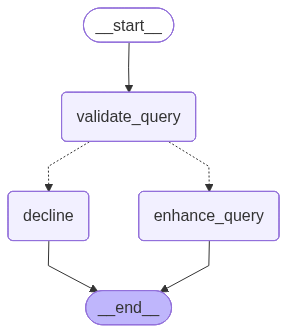

In [16]:
png_bytes = graph.get_graph(xray=True).draw_mermaid_png()
Image.open(io.BytesIO(png_bytes))

In [31]:
user_input = "LeBron James scored 50 points in the 2024 NBA Finals Game 7"
#user_input = "LeBron James was a golf player?" # Should be declined
#user_input = "The capital of France is Paris." # Should be declined

In [32]:
# Example usage
config = {"configurable": {"thread_id": "1"}}

initial_state = VerificationState(
    user_input=user_input,
    enhanced_query="",
    search_results=[],
    evidence=[],
    classification=ClassificationResult.DOUBTFUL,
    confidence=0.0,
    explanation="",
    sources=[],
    valid_query=""
)

result = graph.invoke(initial_state, config)

In [33]:
# Display the results
print("=" * 60)
print("VERIFICATION RESULT")
print("=" * 60)
print(f"\nClaim: {result['user_input']}")
print(f"\nValid Query: {result['valid_query']}")
print(f"\nEnhanced Query: {result['enhanced_query']}")
print(f"\nExplanation: {result['explanation']}")

VERIFICATION RESULT

Claim: LeBron James scored 50 points in the 2024 NBA Finals Game 7

Valid Query: YES

Enhanced Query: "LeBron James 50 points 2024 NBA Finals Game 7 stats box score"

Explanation: 
